In [16]:
import torch
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments
from tqdm import tqdm

In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(torch.cuda.get_device_name(0))
    print(torch.cuda.get_device_properties(0))
else:
    device = torch.device("cpu")
    print("using CPU, GPU is not available")

NVIDIA GeForce RTX 4060 Ti
_CudaDeviceProperties(name='NVIDIA GeForce RTX 4060 Ti', major=8, minor=9, total_memory=16379MB, multi_processor_count=34, uuid=b94096d9-a448-c5c8-aacb-e7f2e7d48103, pci_bus_id=1, pci_device_id=0, pci_domain_id=0, L2_cache_size=32MB)


In [18]:
model_name = "google/vit-base-patch16-224"
image_processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)

# Load data

In [19]:
from dataset import GetMedMNIST

d_size = 224

train_dataloader = GetMedMNIST(name='BloodMNIST', split='train', size=d_size)
valid_dataloader = GetMedMNIST(name='BloodMNIST', split='val', size=d_size)
test_dataloader = GetMedMNIST(name='BloodMNIST', split='test', size=d_size)

In [20]:
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=train_dataloader.n_classes,
    id2label={str(i): c for i, c in enumerate(train_dataloader.label_str)},
    label2id={c: str(i) for i, c in enumerate(train_dataloader.label_str)},
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
training_args = TrainingArguments(
  output_dir="./BloodMNIST_ViT",
  per_device_train_batch_size=128,
  num_train_epochs=5,
  eval_strategy='epoch',
  save_strategy='epoch',
  fp16=True,
  logging_steps=374,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)


In [22]:
from evaluate import load
import numpy as np

accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="weighted")
  return {**accuracy_score, **f1_score}
     

In [23]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataloader,
    eval_dataset=valid_dataloader,
    tokenizer=image_processor
)

/tmp/ipykernel_66662/80359912.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Train

In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.034597,0.987734,0.987754
2,No log,0.036112,0.988902,0.988902
3,No log,0.027212,0.992407,0.992411
4,0.074200,0.028811,0.989486,0.989469
5,0.074200,0.028229,0.990070,0.990057


TrainOutput(global_step=470, training_loss=0.059393129133163615, metrics={'train_runtime': 340.4374, 'train_samples_per_second': 175.642, 'train_steps_per_second': 1.381, 'total_flos': 4.633882697754132e+18, 'train_loss': 0.059393129133163615, 'epoch': 5.0})

In [25]:
trainer.evaluate(test_dataloader)

{'eval_loss': 0.03541412949562073,
 'eval_accuracy': 0.9912306343174511,
 'eval_f1': 0.9912358114298478,
 'eval_runtime': 7.7957,
 'eval_samples_per_second': 438.83,
 'eval_steps_per_second': 54.902,
 'epoch': 5.0}

In [26]:
outputs = trainer.predict(test_dataloader)
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# Evaluation

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

def eval_model(labels, preds):
    cf_matrix = confusion_matrix(labels, preds)
    sns.heatmap(cf_matrix, annot=True, cmap='coolwarm', fmt='.0f')

    acc = accuracy_score(labels, preds)

    f1 = f1_score(labels, preds, average='weighted')

    class_report = classification_report(labels, preds)
    print(f'model accuracy: {acc*100:.2f}, f1 weighted: {f1:.4f}')
    print(class_report)

model accuracy: 99.12, f1 weighted: 0.9912
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       244
           1       1.00      1.00      1.00       624
           2       0.99      0.99      0.99       311
           3       0.97      0.99      0.98       579
           4       0.99      1.00      0.99       243
           5       0.99      0.99      0.99       284
           6       0.99      0.98      0.99       666
           7       1.00      1.00      1.00       470

    accuracy                           0.99      3421
   macro avg       0.99      0.99      0.99      3421
weighted avg       0.99      0.99      0.99      3421



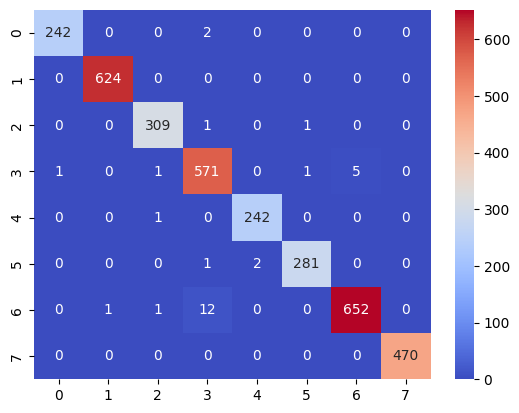

In [28]:
eval_model(y_true, y_pred)

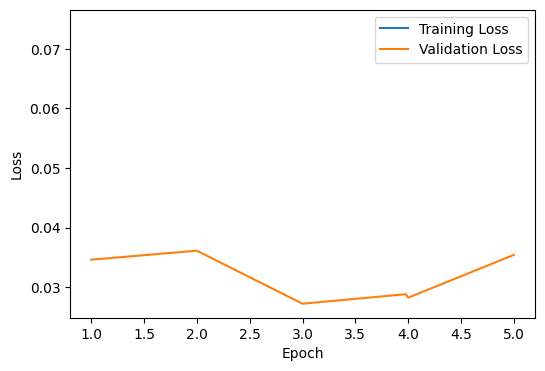

In [29]:
import matplotlib.pyplot as plt

data = trainer.state.log_history
epochs = [entry['epoch'] for entry in data]
train_losses = [entry['loss'] for entry in data if 'loss' in entry]
eval_losses = [entry['eval_loss'] for entry in data if 'eval_loss' in entry]
plt.figure(figsize=(6, 4))

plt.plot(epochs[:len(train_losses)], train_losses, label='Training Loss')
plt.plot(epochs[:len(eval_losses)], eval_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

ROC Score: 0.999


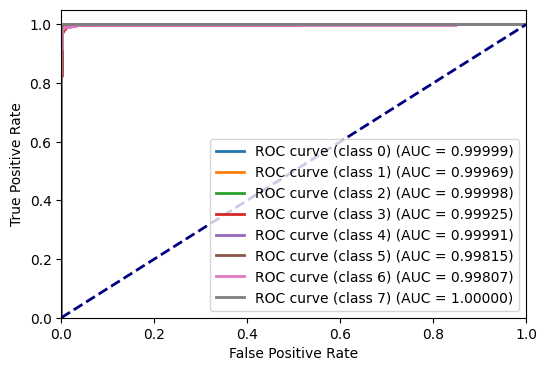

In [30]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import torch

true_labels = outputs.label_ids.reshape(-1)
predictions = torch.softmax(torch.tensor(outputs.predictions), dim=1).numpy()

roc_score = roc_auc_score(true_labels, predictions, multi_class='ovo', average='weighted')
print(f"ROC Score: {roc_score:.3f}")

num_classes = predictions.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((true_labels == i).astype(int), predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 4))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d) (AUC = %0.5f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()